# Task3 GROUND-OBJECT CLASSIFICATION 

### 本任务的目的是通过KAGGLE遥感数据集的训练熟悉基于Deeplabv3+网络语义分割流程。
1. 学习深度学习模型库的调用
2. 学习遥感数据切片方案
3. 学习Deeplabv3+网络
4. 学习精度评价方法

In [19]:
import pandas as pd
import numpy as np
import os
import time
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout,BatchNormalization,ZeroPadding2D,add, Flatten,Activation,AveragePooling2D,Dense
# from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,CSVLogger
from tensorflow.keras.layers import Lambda
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_curve, auc
import h5py
import gdal
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
from PIL import Image
from all_model import all_model
# from historycal import LossHistory



# patches producing

In [20]:
def regular_crop(imagearray, crop_sz,step=256):
    data_all = []
    for i in np.arange(1):
        data = []
        x=0
#         src_img_row,src_img_col=(imagearray.size)[0:2]
        row_num = ((imagearray.shape)[0] - step) // step  ###最多能裁剪几行 几列
        col_num=((imagearray.shape)[1] - step) // step
    #print(row_num,col_num)
        x_start=0
        y_start=0
        for h in range(row_num):
            for w in range(col_num):
                crop_img = imagearray[crop_sz*h+y_start:crop_sz*(h+1)+y_start, crop_sz*w+x_start:crop_sz*(w+1)+x_start,:]               
#                 crop_img= imagearray.crop((step * h, step * w,step * h + crop_sz,step * w + crop_sz))
                data.append(crop_img)
                x=x+1
                # if x % 10 ==0:
                    # print("processing....patch:"+str(i)+"...No.:"+str(x))
                    
        data=np.array(data)
        # print("processing....patch:"+str(i)+"..Total.No.:"+str(data.shape))
        if i == 0:
            data_all = data
        else:
            data_all=np.concatenate((data_all, data), axis = 0)
    return data_all
def label_hot(label,n_label=1):
    listlabel=[]
    for i in label:
        mask=i.flatten()
        mask=to_categorical(mask, num_classes=n_label)
        listlabel.append(mask)
    msk=np.asarray(listlabel,dtype='uint16')
    msk=msk.reshape((label.shape[0],label.shape[1],label.shape[2],n_label))
#     print(msk.shape)
    return msk
 
def changelabel(arr,a):
    arr=np.array(arr)
    new=arr*0
    new[np.where(arr==a)]=1
    return new
def get_normalized_patches(data,value,n_label=1):
    img = data[:,:,:,0:3]/value
    msk = data[:,:,:,-1]
    # msk = changelabel(msk,4)
    msk = label_hot(msk,n_label)
    # msk = np.expand_dims(msk,axis=3)
    return img,msk
def post_normalize_image(img,value):
    return img/value
def patches_generator(allimage,crop_sz):
    allarray=[]
    for index, value in enumerate(allimage):
        # print(value.shape)
        singlearr=regular_crop(value,crop_sz)
    # allarray.append(array)
        if index == 0:
            allarray = singlearr
            # print(allarray.shape,singlearr.shape)
        else:
            allarray=np.concatenate((allarray, singlearr), axis = 0)
            # print(allarray.shape)
    print(allarray.shape)
    return(allarray)
def plot_func(data,label,key):
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow(Image.fromarray(np.uint8((data[i,:,:,:3])*255)))
    plt.show()
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow((label[i,:,:,key]),cmap="gray")
    plt.show()
def val_plot_func(data,label,pred,key):
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow(Image.fromarray(np.uint8((data[i,:,:,:3])*255)))
    plt.show()
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow((label[i,:,:,key]),cmap="gray")
    plt.show()
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow((pred[i,:,:,key]),cmap="gray")
    plt.show()

In [15]:
class1_hdf5_path ='Y:\\Deep learning teaching\\task3\\data\\kaggle_rgb_4b_6c.hdf5'
fd = h5py.File(class1_hdf5_path)
fd.keys()
data=fd['data']
label=fd['label']
label=changelabel(label,4)
# fd.close
print(data.shape,label.shape)
n_label=2

D:\Anaconda3\envs\tf20\lib\site-packages\ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


(15, 3840, 3840, 3) (15, 3840, 3840, 1)


In [16]:
allimage=np.concatenate((data,label),axis=3)
# print(allimage.shape)
allpatches=patches_generator(allimage[:-1],256)
images,labels=get_normalized_patches(allpatches,10000.0,n_label)
print(images.shape,labels.shape)
testimage=allimage[-1,:,:,:-1]
testlabel=allimage[-1,:,:,-1]
print(testimage.shape,testlabel.shape)

(2744, 256, 256, 4)
(2744, 256, 256, 3) (2744, 256, 256, 2)
(3840, 3840, 3) (3840, 3840)


(2195, 256, 256, 3) (549, 256, 256, 3) (2195, 256, 256, 2) (549, 256, 256, 2)


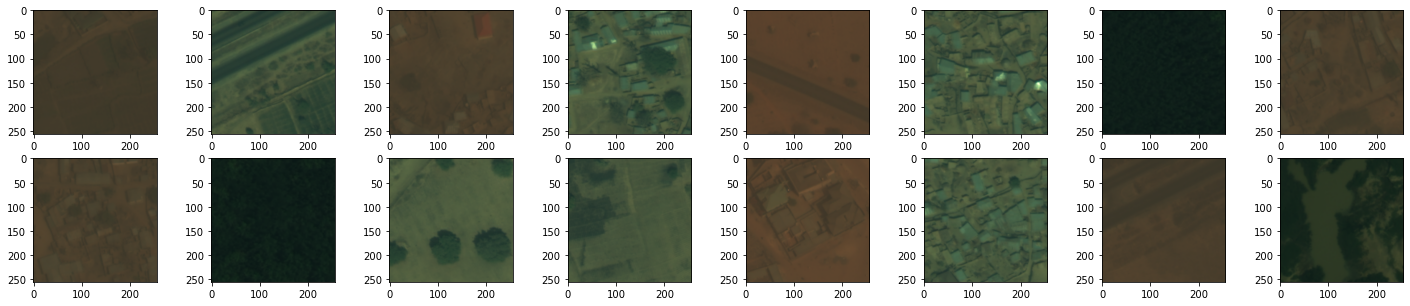

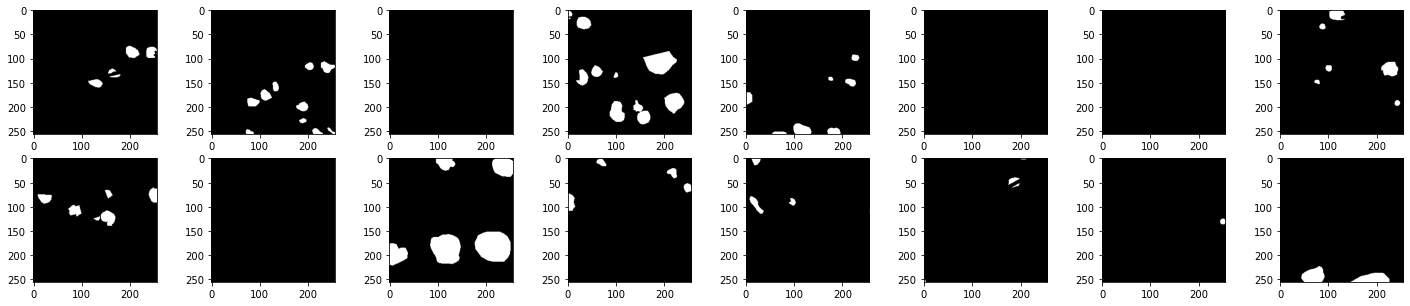

In [17]:
xtrain,xtest,ytrain,ytest=train_test_split(images,labels,test_size=0.2,random_state=42)
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)
plot_func(xtrain,ytrain,1)

# Model Training

In [21]:
loss='categorical_crossentropy'#'binary_crossentropy'
optimizer=Adam()#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#Adam()#SGD(),Adamax(),Adadelta()R
loss_weights=''
metrics=['accuracy']
input_height=256
input_width=256
batch_size=15
epoch=20
nclass=n_label
nchannel=xtrain.shape[-1]
num_train=xtrain.shape[0]
num_val=xtest.shape[0]
ATM=all_model(loss,loss_weights,optimizer,metrics,input_height,input_width,nclass,nchannel)
nickname='DEEPLABV3plus'


In [22]:
model=ATM.DEEPLABV3plus()#FCN8,UNET_VGG,UNET_MINI,SQUEESE_UNET,DEEPLABV3plus
# model.summary()

In [39]:
begin_time = time.time()          
checkpoint_DIR = "./prediction\\"
if not os.path.exists(checkpoint_DIR):
    os.makedirs(checkpoint_DIR) 
model_checkpoint = ModelCheckpoint(filepath=checkpoint_DIR+nickname+"-{epoch:02d}e-val_loss{val_loss:2f}.hdf5",monitor="val_loss",save_best_only=True,mode='auto')
# histories=LossHistory()
csvlogger =CSVLogger(filename=checkpoint_DIR+nickname+'-'+str(epoch)+'-log.csv', separator=',', append=False)
# result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,CSVLogger])
result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,csvlogger])
end_time = time.time()
print('time lapsing {0} s \n'.format(end_time - begin_time))

Epoch 1/20
147/147 [==============================] - 113s 683ms/step - loss: 0.2602 - accuracy: 0.9033 - val_loss: 0.2990 - val_accuracy: 0.9224
Epoch 2/20
147/147 [==============================] - 97s 658ms/step - loss: 0.1662 - accuracy: 0.9358 - val_loss: 0.3493 - val_accuracy: 0.9224
Epoch 3/20
147/147 [==============================] - 97s 658ms/step - loss: 0.1661 - accuracy: 0.9355 - val_loss: 0.3766 - val_accuracy: 0.9224
Epoch 4/20
147/147 [==============================] - 99s 673ms/step - loss: 0.1466 - accuracy: 0.9448 - val_loss: 0.3272 - val_accuracy: 0.9225
Epoch 5/20
147/147 [==============================] - 97s 659ms/step - loss: 0.1381 - accuracy: 0.9466 - val_loss: 0.1507 - val_accuracy: 0.9405
Epoch 6/20
147/147 [==============================] - 97s 660ms/step - loss: 0.1347 - accuracy: 0.9471 - val_loss: 0.3000 - val_accuracy: 0.9277
Epoch 7/20
147/147 [==============================] - 97s 658ms/step - loss: 0.1266 - accuracy: 0.9511 - val_loss: 0.3772 - val_a

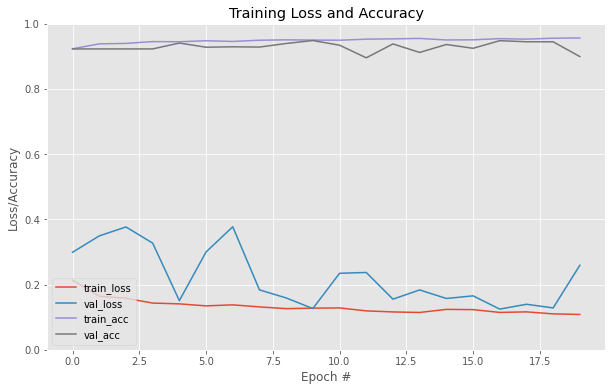

In [40]:
def plot_fig(H,outdir):
    N=len(result.history['loss'])
    plt.style.use("ggplot")
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.ylim(0,1)

    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(outdir)
plot_fig(result,nickname+"_Loss_Acc_epoch.png")

In [41]:
i=0
pred=model.predict(xtest[:200],batch_size=20)

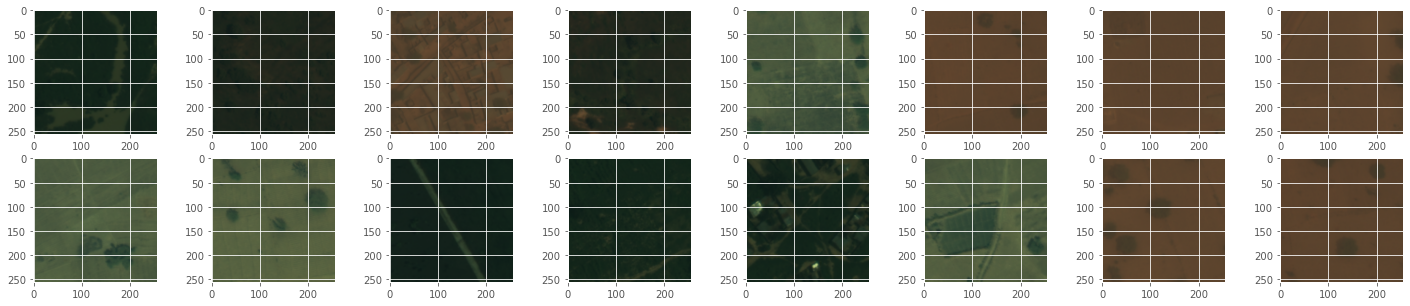

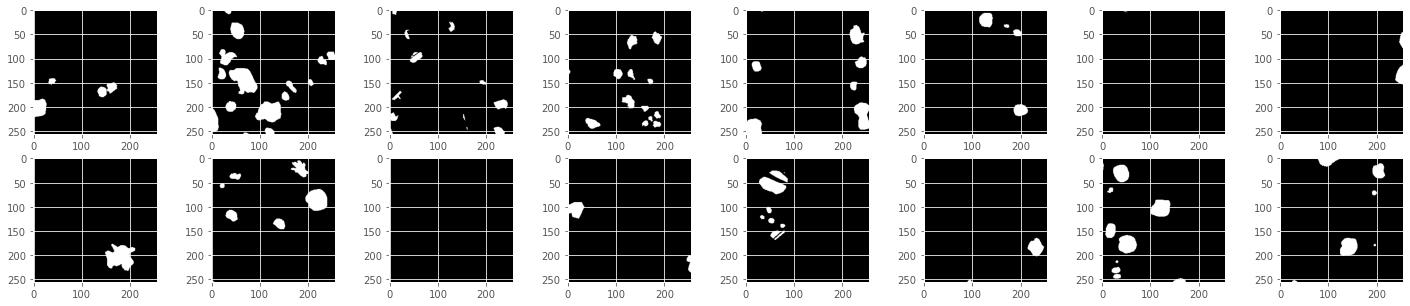

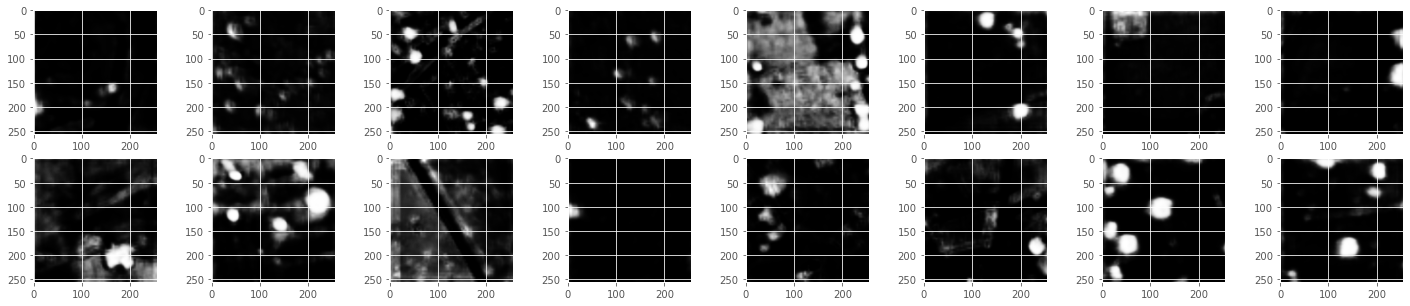

In [44]:
val_plot_func(xtest[i:i+20],ytest[i:i+20],pred[i:i+20],1)
i+=20

# Prediction

In [45]:
def predict(image,ProductDir,shotname,threshold,n_label,is_score=1):
    #print("[INFO] loading network...")
    stride=128   #128
    image_size=256
    h,w,c = image.shape
    padding_h = (h//stride + 1) * stride
    padding_w = (w//stride + 1) * stride
    padding_img = np.zeros((padding_h,padding_w,c),dtype=np.float32)
    padding_img[0:h,0:w,:] = image[:,:,:]
    padding_img = padding_img.astype("float")
    # padding_img = img_to_array(padding_img)
    # 	print ('src:',padding_img.shape)
    mask_whole = np.zeros((padding_h,padding_w,n_label),dtype=np.float32)
    print('all images='+str((padding_h//stride)*(padding_w//stride)))
    for i in range(padding_h//stride):
        if i % 10 ==0 :
            print('processing.....' +str(i)+'    of   '+str(padding_h//stride))
        for j in range(padding_w//stride):
            crop = padding_img[i*stride:i*stride+image_size,j*stride:j*stride+image_size,:]
            #         print(crop.shape)
            ch,cw,c = crop.shape
            if ch != image_size or cw != image_size:
            #             print ('invalid size!')
                continue
            crop = np.expand_dims(crop, axis=0)
            pred = model.predict(crop,verbose=0)
#             print(pred.shape)
            #pred=np.argmax(pred, axis=-1)
            #print (np.unique(pred))
            pred = pred.reshape((image_size,image_size,n_label)).astype(np.float32)
#             print(pred.shape)
            #print 'pred:',pred.shape
            mask_whole[i*stride:i*stride+image_size,j*stride:j*stride+image_size,:] = pred[:,:,:]
            #mask_whole[i * stride:i * stride + image_size , j * stride:j * stride + image_size,:] = pred[:,:,:]

    img_final = mask_whole[0:h, 0:w,:]
#    print(np.mean(img_final))
    imgarr=np.zeros((h,w),dtype=np.uint8)

#    if is_score==1:
#        for k in range(n_label):
#            im=np.array((img_final[:,:,i]*256),dtype=np.uint8)
#            imwrite((ProductDir+shotname+'_score'+str(k)+'.png'),im)
#            imgarr[img_final[:,:,i]>threshold]=1
#            imgarr[img_final[:,:,i]<=threshold]=0
#            im=np.array(imgarr*255,dtype=np.uint8)   
#            cv2.imwrite((ProductDir+shotname+'_pred'+str(k)+'.png'),im)

    #img_final[img_final>=1]=1
    pred=np.argmax(img_final, axis=-1)
    cv2.imwrite((ProductDir+shotname+'_prdlabels.png'),pred*255)
    #print (np.unique(img_final))
    return pred,img_final

def out_report(gt_arr,label_arr,out_csv):
    # gt_arr=Load_image_by_Gdal(gt)
    gt_reshape=gt_arr.reshape((gt_arr.shape[0]*gt_arr.shape[1],1))
    label_reshape=label_arr.reshape((label_arr.shape[0]*label_arr.shape[1],1))
    acc=classification_report(gt_reshape,label_reshape,output_dict=True)
    df=pd.DataFrame(acc).transpose()
    df.to_csv(out_csv,index=True)   

# Evaluation

In [46]:
PREDICTION_DIR = "./prediction\\"+nickname+'\\'
if not os.path.exists(PREDICTION_DIR):
    os.makedirs(PREDICTION_DIR)
msk_result,mask_arr=predict(testimage/10000.0,PREDICTION_DIR,nickname,0.5,n_label)
out_report(testlabel,msk_result,PREDICTION_DIR+'matrics.csv')

all images=961
processing.....0    of   31
processing.....10    of   31
processing.....20    of   31
processing.....30    of   31


In [ ]:
plt.imshow(testlabel,cmap='gray')

In [ ]:
plt.imshow(msk_result,cmap='gray')